In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
!ls Data

Attack


In [4]:
path = "./different_cards/"
image_size = (96, 96)
train_data = image_dataset_from_directory(path, validation_split=0.2,
                                        subset="training",
                                        shuffle = True,
                                        batch_size = 16, 
                                        seed=123,
                                        image_size = image_size)

val_data = image_dataset_from_directory(path, validation_split=0.2,
                                        subset="validation",
                                        shuffle = True,
                                        batch_size = 16, 
                                        seed=123,
                                        image_size = image_size)

Found 128 files belonging to 3 classes.
Using 103 files for training.
Found 128 files belonging to 3 classes.
Using 25 files for validation.


In [5]:
class_names = train_data.class_names
print(class_names)

['arts', 'buster', 'quick']


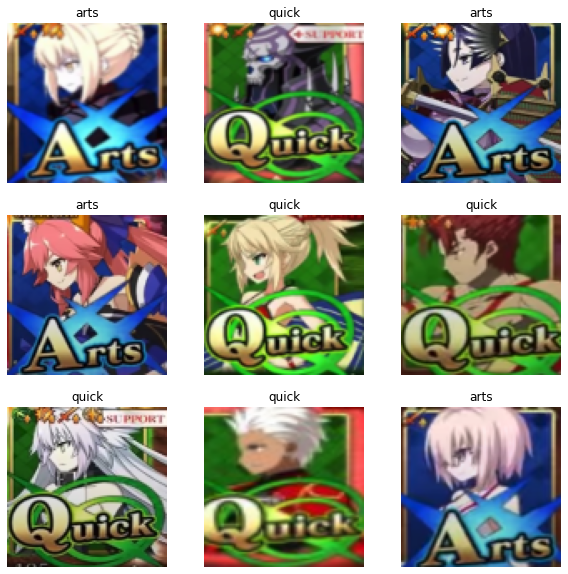

In [6]:
# lets visualize the data: 
plt.figure(figsize=(10,10))
for images, labels in val_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, label_batch in train_data:
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch)
    break

(16, 96, 96, 3)
(16,)
tf.Tensor([1 0 0 2 0 1 1 2 0 1 2 0 0 1 0 2], shape=(16,), dtype=int32)


In [10]:
# normalize rgb data, and rescale to 0 to 1 

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 



In [84]:
# set up data augmentation layer, since we don't have too much data (these will only be active during training)
"""
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
])

for image, _ in train_data.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/ 255)
        plt.axis('off')

"""

# on second thought augmentation doesn't really help us here

"\ndata_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),\n                                         tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),\n])\n\nfor image, _ in train_data.take(1):\n    plt.figure(figsize=(10, 10))\n    first_image = image[0]\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n        plt.imshow(augmented_image[0]/ 255)\n        plt.axis('off')\n\n"

In [11]:
image_shape = image_size + (3,)

base_model = tf.keras.applications.ResNet50(input_shape= image_shape,
                                               include_top = False,
                                               weights='imagenet')

In [12]:
# let's see what it does to a batch of images: (generates a 3x3x1280 block of features)
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 3, 3, 2048)


In [13]:
# freeze the convolutional base before we compile and train, so that the good feature extraction layers is preserved
base_model.trainable = False

# check model architecture
#base_model.summary()

In [14]:
# to generate predictions from the block of features, we need a average pool to convert features from 3x3
# to a single 1280 element vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
print(feature_batch_average[0])

(16, 2048)
tf.Tensor([0.         1.5587183  0.         ... 0.         0.34921837 0.        ], shape=(2048,), dtype=float32)


In [15]:
# then we just need to apply a dense layer to this ( makes sense)
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(prediction_batch[0][2])

(16, 3)
tf.Tensor(0.28632006, shape=(), dtype=float32)


In [27]:
# the model is actually build by chaining toghether the data 
inputs = tf.keras.Input(shape=(96, 96, 3))
x = normalization_layer(inputs)
x = base_model(x, training=False)
x = global_average_layer(x) 
x = tf.keras.layers.Dense(2048, activation="relu")(x)
x = tf.keras.layers.Dense(2048, activation="relu")(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [28]:
# compile model, using categorial crossentropy loss
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense (Dense)                (None, 3)                

In [29]:
# check initial accuracy 
epochs = 10
loss0, accuracy0 = model.evaluate(val_data)

2/2 [==============================] - 0s 48ms/step - loss: 1.1611 - accuracy: 0.3200


In [30]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = val_data)

Epoch 1/10
7/7 [==============================] - 1s 204ms/step - loss: 1.1147 - accuracy: 0.4757 - val_loss: 1.4434 - val_accuracy: 0.2400
Epoch 2/10
7/7 [==============================] - 1s 203ms/step - loss: 1.1366 - accuracy: 0.4660 - val_loss: 1.1849 - val_accuracy: 0.3200
Epoch 3/10
7/7 [==============================] - 1s 205ms/step - loss: 1.1109 - accuracy: 0.3883 - val_loss: 1.2538 - val_accuracy: 0.2400
Epoch 4/10
7/7 [==============================] - 1s 201ms/step - loss: 1.0408 - accuracy: 0.4854 - val_loss: 1.0519 - val_accuracy: 0.4800
Epoch 5/10
7/7 [==============================] - 1s 204ms/step - loss: 0.9998 - accuracy: 0.4272 - val_loss: 1.1742 - val_accuracy: 0.2400
Epoch 6/10
7/7 [==============================] - 1s 205ms/step - loss: 0.9955 - accuracy: 0.5049 - val_loss: 1.0715 - val_accuracy: 0.5600
Epoch 7/10
7/7 [==============================] - 1s 205ms/step - loss: 0.9791 - accuracy: 0.5049 - val_loss: 1.0560 - val_accuracy: 0.2400
Epoch 8/10
7/7 [====

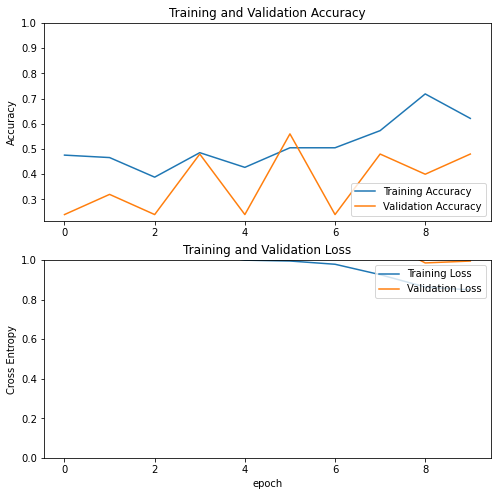

In [31]:
# function to check accuracy and loss

def plot_acc_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
plot_acc_and_loss(history)

In [33]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = val_data)

Epoch 1/10
7/7 [==============================] - 1s 207ms/step - loss: 0.5699 - accuracy: 0.7864 - val_loss: 0.7643 - val_accuracy: 0.6000
Epoch 2/10
7/7 [==============================] - 1s 203ms/step - loss: 0.5437 - accuracy: 0.8350 - val_loss: 0.6777 - val_accuracy: 0.6800
Epoch 3/10
7/7 [==============================] - 1s 205ms/step - loss: 0.5266 - accuracy: 0.7864 - val_loss: 0.7152 - val_accuracy: 0.6000
Epoch 4/10
7/7 [==============================] - 1s 209ms/step - loss: 0.4819 - accuracy: 0.9029 - val_loss: 0.5991 - val_accuracy: 0.8000
Epoch 5/10
7/7 [==============================] - 1s 212ms/step - loss: 0.4469 - accuracy: 0.8738 - val_loss: 0.7002 - val_accuracy: 0.6000
Epoch 6/10
7/7 [==============================] - 1s 211ms/step - loss: 0.4255 - accuracy: 0.9029 - val_loss: 0.5578 - val_accuracy: 0.8800
Epoch 7/10
7/7 [==============================] - 2s 215ms/step - loss: 0.4220 - accuracy: 0.9515 - val_loss: 0.6850 - val_accuracy: 0.6000
Epoch 8/10
7/7 [====

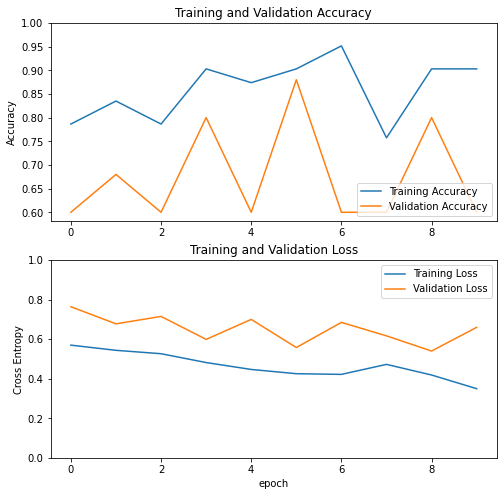

In [34]:
plot_acc_and_loss(history)

In [37]:
# update learning rate and train more
from tensorflow.keras import backend as K 

K.set_value(model.optimizer.learning_rate, 0.00005)
print("New learning rate: ", model.optimizer.learning_rate.numpy())

New learning rate:  5e-05


In [38]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = val_data)

Epoch 1/10
7/7 [==============================] - 1s 213ms/step - loss: 0.3647 - accuracy: 0.8447 - val_loss: 0.5515 - val_accuracy: 0.6800
Epoch 2/10
7/7 [==============================] - 1s 210ms/step - loss: 0.3429 - accuracy: 0.9515 - val_loss: 0.4768 - val_accuracy: 0.9200
Epoch 3/10
7/7 [==============================] - 1s 209ms/step - loss: 0.3358 - accuracy: 0.9515 - val_loss: 0.5245 - val_accuracy: 0.6800
Epoch 4/10
7/7 [==============================] - 1s 213ms/step - loss: 0.3263 - accuracy: 0.9417 - val_loss: 0.5023 - val_accuracy: 0.7600
Epoch 5/10
7/7 [==============================] - 2s 217ms/step - loss: 0.3147 - accuracy: 0.9417 - val_loss: 0.5115 - val_accuracy: 0.7200
Epoch 6/10
7/7 [==============================] - 2s 223ms/step - loss: 0.3084 - accuracy: 0.9417 - val_loss: 0.5004 - val_accuracy: 0.7200
Epoch 7/10
7/7 [==============================] - 2s 225ms/step - loss: 0.3047 - accuracy: 0.9612 - val_loss: 0.4484 - val_accuracy: 0.8800
Epoch 8/10
7/7 [====

In [51]:
# check the predictions of the network 

image_batch, label_batch = val_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = [np.where(x == max(x))[0][0] for x in predictions]
print(predictions)


[2, 2, 1, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0, 1]


In [1]:
def plot_pred(predictions):
    plt.figure(figsize=(10, 10))
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[predictions[i]])
      plt.axis("off")


In [55]:
# everything is fine except for 1, I'd say thats fine for now, lets save this model
model.save('./feature_extractor_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./feature_extractor_model/assets


# Section2: reloading and finetuning

In [75]:
model2 = tf.keras.models.load_model('./feature_extractor_model')

OSError: SavedModel file does not exist at: ./feature_extractor_model/{saved_model.pbtxt|saved_model.pb}

In [57]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense (Dense)                (None, 3)                

In [64]:
model.layers[2].trainable = True

In [65]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense (Dense)                (None, 3)                

In [71]:
# only unfreeze the last 75 layers
model.layers[2].trainable = False
for layer in range(100, 175):
    (model.layers[2]).layers[layer].trainable = True

In [72]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense (Dense)                (None, 3)                

In [73]:
# recompile the model with lower learning rate 
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [76]:
history = model.fit(train_data,
                    epochs=5,
                    validation_data = val_data)

Epoch 1/5
7/7 [==============================] - 2s 293ms/step - loss: 0.2809 - accuracy: 0.9612 - val_loss: 0.4713 - val_accuracy: 0.8000
Epoch 2/5
7/7 [==============================] - 1s 203ms/step - loss: 0.2759 - accuracy: 0.9417 - val_loss: 0.4677 - val_accuracy: 0.8000
Epoch 3/5
7/7 [==============================] - 1s 205ms/step - loss: 0.2742 - accuracy: 0.9515 - val_loss: 0.4382 - val_accuracy: 0.8800
Epoch 4/5
7/7 [==============================] - 1s 207ms/step - loss: 0.2710 - accuracy: 0.9709 - val_loss: 0.4460 - val_accuracy: 0.8800
Epoch 5/5
7/7 [==============================] - 1s 214ms/step - loss: 0.2688 - accuracy: 0.9612 - val_loss: 0.4407 - val_accuracy: 0.8800


In [77]:
history = model.fit(train_data,
                    epochs=3,
                    validation_data = val_data)

Epoch 1/3
7/7 [==============================] - 1s 212ms/step - loss: 0.2671 - accuracy: 0.9709 - val_loss: 0.4222 - val_accuracy: 0.8800
Epoch 2/3
7/7 [==============================] - 1s 206ms/step - loss: 0.2652 - accuracy: 0.9709 - val_loss: 0.4334 - val_accuracy: 0.8800
Epoch 3/3
7/7 [==============================] - 1s 212ms/step - loss: 0.2634 - accuracy: 0.9612 - val_loss: 0.4481 - val_accuracy: 0.8400


In [78]:
history = model.fit(train_data,
                    epochs=3,
                    validation_data = val_data)

Epoch 1/3
7/7 [==============================] - 1s 205ms/step - loss: 0.2619 - accuracy: 0.9515 - val_loss: 0.4469 - val_accuracy: 0.8400
Epoch 2/3
7/7 [==============================] - 1s 207ms/step - loss: 0.2595 - accuracy: 0.9612 - val_loss: 0.4324 - val_accuracy: 0.8800
Epoch 3/3
7/7 [==============================] - 1s 210ms/step - loss: 0.2588 - accuracy: 0.9709 - val_loss: 0.4216 - val_accuracy: 0.9200


In [79]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = val_data)

Epoch 1/10
7/7 [==============================] - 1s 208ms/step - loss: 0.2590 - accuracy: 0.9709 - val_loss: 0.4331 - val_accuracy: 0.8800
Epoch 2/10
7/7 [==============================] - 1s 205ms/step - loss: 0.2557 - accuracy: 0.9709 - val_loss: 0.4116 - val_accuracy: 0.8800
Epoch 3/10
7/7 [==============================] - 1s 211ms/step - loss: 0.2547 - accuracy: 0.9709 - val_loss: 0.4169 - val_accuracy: 0.8800
Epoch 4/10
7/7 [==============================] - 1s 208ms/step - loss: 0.2511 - accuracy: 0.9709 - val_loss: 0.4183 - val_accuracy: 0.8800
Epoch 5/10
7/7 [==============================] - 1s 210ms/step - loss: 0.2496 - accuracy: 0.9709 - val_loss: 0.4219 - val_accuracy: 0.8800
Epoch 6/10
7/7 [==============================] - 1s 212ms/step - loss: 0.2479 - accuracy: 0.9709 - val_loss: 0.4222 - val_accuracy: 0.8800
Epoch 7/10
7/7 [==============================] - 2s 216ms/step - loss: 0.2473 - accuracy: 0.9612 - val_loss: 0.4260 - val_accuracy: 0.8800
Epoch 8/10
7/7 [====

In [81]:
# unfreeze the whole resnet
model.layers[2].trainable = True
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense (Dense)                (None, 3)                

In [82]:
# recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [83]:
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = val_data)

Epoch 1/10
7/7 [==============================] - 6s 895ms/step - loss: 4.0862 - accuracy: 0.4757 - val_loss: 1.7161 - val_accuracy: 0.4400
Epoch 2/10
7/7 [==============================] - 5s 726ms/step - loss: 0.9383 - accuracy: 0.6311 - val_loss: 1.5322 - val_accuracy: 0.2800
Epoch 3/10
7/7 [==============================] - 5s 741ms/step - loss: 0.9804 - accuracy: 0.5728 - val_loss: 0.7612 - val_accuracy: 0.7600
Epoch 4/10
7/7 [==============================] - 5s 751ms/step - loss: 0.7275 - accuracy: 0.6893 - val_loss: 0.8197 - val_accuracy: 0.5600
Epoch 5/10
7/7 [==============================] - 5s 762ms/step - loss: 0.4662 - accuracy: 0.8155 - val_loss: 0.4707 - val_accuracy: 0.8800
Epoch 6/10
7/7 [==============================] - 5s 779ms/step - loss: 0.3668 - accuracy: 0.9029 - val_loss: 0.4666 - val_accuracy: 0.6800
Epoch 7/10
7/7 [==============================] - 5s 783ms/step - loss: 0.2689 - accuracy: 0.9320 - val_loss: 0.2476 - val_accuracy: 1.0000
Epoch 8/10
7/7 [====

[2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 0, 1]


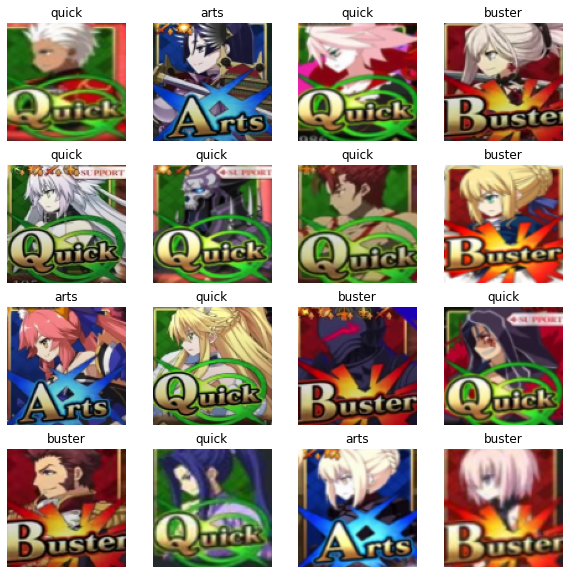

In [85]:
# check the predictions of the network 

image_batch, label_batch = val_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = [np.where(x == max(x))[0][0] for x in predictions]
print(predictions)

plot_pred(predictions)

In [86]:
# perfect! lets save this model 
model.save("card_classifier_model")

INFO:tensorflow:Assets written to: card_classifier_model/assets


In [ ]:
# save model architecture to json
json_arch = model.to_json()
with open("card_class_model_arch.json", "w") as f:
    f.write(json_arch)
f.close
# save model weights to h5 
model.save_weights(path="card_clas")